# Using Python in HPC

Brian Skjerven  
Marco DeLapierre  
Maciej Cytowski  

![Pawsey logo](../img/pawsey.jpg)

## Overview

* Python: The Good and the Bad
* Best Practices for Python in HPC
* Python Libraries
    * Numerical (NumPy, SciPy)
    * I/O (H5Py, PyTables)
    * Machine Learning (PyTorch)
* Parallel Python
* PySpark
* Other Topics (e.g., ML, CUDA)


![Python logo](../img/python_logo.png)

* Dynamic, interpreted, interactive
* Object-oriented
* Automatic memory management
* Range of external libraries and modules
* Extendable with C, C++, Fortran
    * More on this later
* Easy to learn
    * Equally easy to do “dumb” things

# Obligatory xkcd

![xkcd](../img/xkcd_python.png)

# Space Invaders

Here's 37 lines of Python code that creates a fully functioning game

```python
import math, time
import tkinter as tk
from tkinter import Tk, Canvas, PhotoImage, Label, Button

class Game(tk.Frame):
    def __init__(self, parent, *args, **kwargs):
        tk.Frame.__init__(self, parent, *args, **kwargs)
        self.parent = parent
        parent.title("Space Invaders")

        canvas, aliens, lasers = Canvas(parent, width=800, height=400, bg='black'), {}, {}
        canvas.pack()
        i1, i2 = PhotoImage(format = 'gif', file = "alien.gif"), PhotoImage(format = 'gif', file = "laser.gif")
        for x, y, p in [(100+40*j, 160-20*i, 100*i) for i in range(8) for j in range(15)]:
            aliens[canvas.create_image(x, y, image = i1)] = p
        canvas.bind('<Button-1>', lambda e: lasers.update({canvas.create_image(e.x, 390, image=i2): 10}))
        while aliens:
            try:
                for l in lasers:
                    canvas.move(l, 0, -5)
                    if canvas.coords(l)[1]<0:
                        canvas.delete(l); del lasers[l]
                for a in aliens:
                    canvas.move(a, 2.0*math.sin(time.time()),0)
                    p = canvas.coords(a)
                    items = canvas.find_overlapping(p[0]-5, p[1]-5, p[0]+5, p[1]+5)
                    for i in items[1:2]:
                        canvas.delete(a); del aliens[a]; canvas.delete(i); del lasers[i]
                time.sleep(0.02); root.update()
            except: pass

if __name__ == "__main__":
    root = tk.Tk()
    Game(root).pack(side="top", fill="both", expand=True)
    root.mainloop()
```

![Space Invaders Python](../img/space_invaders.png)

Try that in C++  
(code is available in this repo)

# 1D Heat Equation

![1D Heat Eqn](../img/1dheat.png)
* Time-dependent
* Finite differences, Backward Euler
* Benchmark:
    * Python 2.7.13 (using NumPy)
    * GCC 7.2.0 (using PETSc)
    * Serial test (Single node of Magnus)
    * Discretisation using 10-100 million points

![Solving 1D Heat Eqn](../img/1dheat_plot.png)

* Left axis is Python runtime
* Right axis is PETSc runtime
* Python failed at 100K grid points
    * Memory limitation (64GB on Magnus)
* PETSc also ran on 10 million & 100 million grid points

# Python Performace

Simple fact: Python is slower than a compiled language like C or Fortran  
  
Why?
   * Python objects can be inefficient
   * Compiled vs Interpreted languages
   * Dynamic typing
   

# Interpreters

Ok...time to be pedantic

Python is technically a specification for a language that can be implemented any number of ways.  When people refer to using Python, they're also talking about the **interpreter** that they use.  The interpreter is a separate program that executes the source code, as opposed to a compiled language where source code is translated into instructions that your target machine can understand.

There are benefits to interpreted languages:
* Development speed (no need to compile)
* Easier to implement (compilers are hard!)
* Code distribution is easier

And disadvantages:
* Performance issues
* Security (code injection)

Most common is **CPython**, but there are other options:
* Jython (Java-based)
* IronPython (.NET Framework/C#)
* PyPY (Python written in...Python)

There are trade-offs with different interpeters; e.g. PyPy gives good performance but is beta for Python 3.

For HPC applications I'd recommend sticking with CPython (or whatever is on your particular system) and focus your efforts on other areas for performance improvement (more on that later).

In [9]:
# Simple function in Python
def test_func(n):
    x = 1
    for i in range(n):
        x += x * i

In [10]:
# Time our function
%timeit test_func(10000)

32.6 ms ± 759 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Here's the Fortran equivalent:

In [11]:
%%file test_func.f

      subroutine test_func(n)
           integer :: n, i
           double precision :: x
    
           x = 1
           do i = 0,n-1
                x = x + (x * 1)
           enddo
      end subroutine test_func

Overwriting test_func.f


We can use the `f2py` tool to compile our Fortran code and call it from Python:

In [12]:
!f2py -c test_func.f -m test_func > /dev/null

In [13]:
from test_func import test_func
%timeit test_func(10000)

141 ns ± 2.56 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


# Python's Memory Layout

![NumPy Array vs Python List](../img/python_memory.png)

* NumPy array is simply a Python object pointing to a C array (which is contiguous)
<br>
* Python list points to a contiguous block of pointers
    * Each points to a different Python object
    * Each object is spread out in memory

# Static vs. Dynamic Typing

Python knows nothing (at runtime) about the variables in your code

* Are they integers? floats? strings

Only knows they exist as Python objects

# Integer Addition in C

```c
int a = 1;
int b = 2;
intc c = a+b;
```

That corresponds to the following steps:

1. Assign `<int> 1` to `a`  
<br>
2. Assign `<int> 2` to `b`  
<br>
3. Call `<binary_add<int,int>(a,b)`  
<br>
4. Assign result to `c`

<img src="../img/c_integer.png" alt="C integer" style="width: 200px;"/>

# Integer Addition in Python
```python
a = 1
b = 2
c = a + b
```

1. Assign `1` to `a`  
    Set `a->PyObject_HEAD->typecde` to integer  
    Set `a->val=1`
    <br>
    
2. Assign `2` to `b`  
    Set `b->PyObject_HEAD->typecde` to integer  
    Set `b->val=2` 
    <br>
    
3. Call `binary_add(a,b)`  
    Find typecode in `a->PyObject_HEAD`  
    `a` is an integer; value is `a->val`  
    Find typecode in `b->PyObject_HEAD`  
    `b` is an integer; value is `b->val`  
    Call `binary_add<int, int>(a->val, b->val)  
    Result is `result`, and type is integer  
    <br>
    
4. Creat Python object `c`  
    Set `c->PyObject_HEAD->typecode` to integer  
    Set `c->val` to `result`  

<img src="../img/python_integer.png" alt="Python integer" style="width: 200px;"/>

# So....what do we do?

![C vs Python](../img/foxtrot.png)

# Leverage the best of both C & Python

* **petsc4py**
    * Python bindings for PETSc (linear algebra package written in C)
    * Uses standard Python objects (e.g. NumPy arrays)
    * Uses a wrapper around compiled PETSc libraries
    * Compute intensive kernels now done in C libraries
    * Use of NumPy arrays means that memory layout is contiguous, and arrays can be accessed by Python and C code  
<br>
* Same 1-D Heat Equation
    * 130 lines of Python code
    * Performance?

![petsc4py](../img/1dheat_petsc4py.png)

![petsc4py log plot](../img/1dheat_petsc4py_log.png)

In [14]:
%matplotlib inline

In [15]:
# Solves Heat equation on a periodic domain, using raw VecScatter
from __future__ import division
import sys, petsc4py
petsc4py.init(sys.argv)

from petsc4py import PETSc
from mpi4py import MPI
import numpy
import matplotlib

class Heat(object):
    def __init__(self,comm,N):
        self.comm = comm
        self.N = N              # global problem size
        self.h = 1/N            # grid spacing on unit interval
        self.n = N // comm.size + int(comm.rank < (N % comm.size)) # owned part of global problem
        self.start = comm.exscan(self.n)
        if comm.rank == 0: self.start = 0
        gindices = numpy.arange(self.start-1, self.start+self.n+1, dtype=int) % N # periodic
        self.mat = PETSc.Mat().create(comm=comm)
        size = (self.n, self.N) # local and global sizes
        self.mat.setSizes((size,size))
        self.mat.setFromOptions()
        self.mat.setPreallocationNNZ((3,1)) # Conservative preallocation for 3 "local" columns and one non-local

        # Allow matrix insertion using local indices [0:n+2]
        lgmap = PETSc.LGMap().create(list(gindices), comm=comm)
        self.mat.setLGMap(lgmap, lgmap)

        # Global and local vectors
        self.gvec = self.mat.getVecRight()
        self.lvec = PETSc.Vec().create(comm=PETSc.COMM_SELF)
        self.lvec.setSizes(self.n+2)
        self.lvec.setUp()
        # Configure scatter from global to local
        isg = PETSc.IS().createGeneral(list(gindices), comm=comm)
        self.g2l = PETSc.Scatter().create(self.gvec, isg, self.lvec, None)

        self.tozero, self.zvec = PETSc.Scatter.toZero(self.gvec)
        self.history = []

        if False:                # Print some diagnostics
            print('[%d] local size %d, global size %d, starting offset %d' % (comm.rank, self.n, self.N, self.start))
            self.gvec.setArray(numpy.arange(self.start,self.start+self.n))
            self.gvec.view()
            self.g2l.scatter(self.gvec, self.lvec, PETSc.InsertMode.INSERT)
            for rank in range(comm.size):
                if rank == comm.rank:
                    print('Contents of local Vec on rank %d' % rank)
                    self.lvec.view()
                comm.barrier()
    def evalSolution(self, t, x):
        assert t == 0.0, "only for t=0.0"
        coord = numpy.arange(self.start, self.start+self.n) / self.N
        x.setArray((numpy.abs(coord-0.5) < 0.1) * 1.0)
    def evalFunction(self, ts, t, x, xdot, f):
        self.g2l.scatter(x, self.lvec, PETSc.InsertMode.INSERT) # lvec is a work vector
        h = self.h
        with self.lvec as u, xdot as udot:
            f.setArray(udot*h + 2*u[1:-1]/h - u[:-2]/h - u[2:]/h) # Scale equation by volume element
    def evalJacobian(self, ts, t, x, xdot, a, A, B):
        h = self.h
        for i in range(self.n):
            lidx = i + 1
            gidx = self.start + i
            B.setValuesLocal([lidx], [lidx-1,lidx,lidx+1], [-1/h, a*h+2/h, -1/h])
        B.assemble()
        if A != B: A.assemble() # If operator is different from preconditioning matrix
        return True # same nonzero pattern
    def monitor(self, ts, i, t, x):
        if self.history:
            lasti, lastt, lastx = self.history[-1]
            if i < lasti + 4 or t < lastt + 1e-4: return
        self.tozero.scatter(x, self.zvec, PETSc.InsertMode.INSERT)
        xx = self.zvec[:].tolist()
        self.history.append((i, t, xx))
    def plotHistory(self):
        try:
            from matplotlib import pylab, rcParams
        except ImportError:
            print("matplotlib not available")
            raise SystemExit
        rcParams.update({'text.usetex':True, 'figure.figsize':(10,6)})
        #rc('figure', figsize=(600,400))
        pylab.title('Heat: TS \\texttt{%s}' % ts.getType())
        x = numpy.arange(self.N) / self.N
        for i,t,u in self.history:
            pylab.plot(x, u, label='step=%d t=%8.2g'%(i,t))
        pylab.xlabel('$x$')
        pylab.ylabel('$u$')
        pylab.legend(loc='upper right')
        #pylab.savefig('heat-history.png')
        pylab.show()

OptDB = PETSc.Options()
ode = Heat(MPI.COMM_WORLD, OptDB.getInt('n',10000))

x = ode.gvec.duplicate()
f = ode.gvec.duplicate()

ts = PETSc.TS().create(comm=ode.comm)
ts.setType(ts.Type.ROSW)        # Rosenbrock-W. ARKIMEX is a nonlinearly implicit alternative.

ts.setIFunction(ode.evalFunction, ode.gvec)
ts.setIJacobian(ode.evalJacobian, ode.mat)

ts.setMonitor(ode.monitor)

ts.setTime(0.0)
ts.setTimeStep(ode.h**2)
ts.setMaxTime(1)
ts.setMaxSteps(100)
ts.setMaxSNESFailures(-1)       # allow an unlimited number of failures (step will be rejected and retried)

snes = ts.getSNES()             # Nonlinear solver
snes.setTolerances(max_it=10)   # Stop nonlinear solve after 10 iterations (TS will retry with shorter step)
ksp = snes.getKSP()             # Linear solver
ksp.setType(ksp.Type.CG)        # Conjugate gradients
pc = ksp.getPC()                # Preconditioner
if False:                       # Configure algebraic multigrid, could use run-time options instead
    pc.setType(pc.Type.GAMG)    # PETSc's native AMG implementation, mostly based on smoothed aggregation
    OptDB['mg_coarse_pc_type'] = 'svd' # more specific multigrid options
    OptDB['mg_levels_pc_type'] = 'sor'

ts.setFromOptions()             # Apply run-time options, e.g. -ts_adapt_monitor -ts_type arkimex -snes_converged_reason
ode.evalSolution(0.0, x)
ts.solve(x)
if ode.comm.rank == 0:
    print('steps %d (%d rejected, %d SNES fails), nonlinear its %d, linear its %d'
          % (ts.getStepNumber(), ts.getStepRejections(), ts.getSNESFailures(),
             ts.getSNESIterations(), ts.getKSPIterations()))

steps 62 (2 rejected, 0 SNES fails), nonlinear its 256, linear its 411


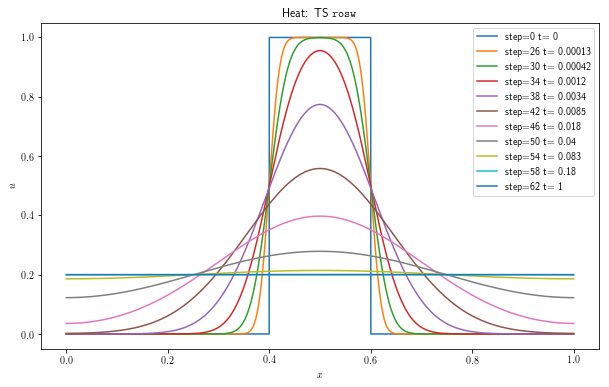

In [16]:
ode.plotHistory()

# Moral of the story

* Need a balance between development effort and computational performance  
<br>
* Python is an excellent "glue" or framework to use for your application  
<br>
* Need to use a compiled language like C or Fortran for the computational kernels
    * But I don't know Fortran?
    * Chances are there's already a module for you...

# Python Tools

![Python Tools](../img/python_tools.png)